In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# Load data
customer = pd.read_csv('E:/archive_5/olist_customers_dataset.csv')
order = pd.read_csv('E:/archive_5/olist_orders_dataset.csv')
item = pd.read_csv('E:/archive_5/olist_order_items_dataset.csv')
review = pd.read_csv('E:/archive_5/olist_order_reviews_dataset.csv')
product = pd.read_csv('E:/archive_5/olist_products_dataset.csv')
category = pd.read_csv('E:/archive_5/product_category_name_translation.csv')
payment = pd.read_csv('E:/archive_5/olist_order_payments_dataset.csv')

In [3]:
df = customer.merge(order, how='inner', on='customer_id')
df = df.merge(item, how='inner', on='order_id')
df = df.merge(payment, how='inner', on='order_id')
df = df.merge(product, how='inner', on='product_id')
df = df.merge(review, how='inner', on='order_id')
df = df.merge(category, how='inner', on='product_category_name')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   order_id                       115609 non-null  object 
 6   order_status                   115609 non-null  object 
 7   order_purchase_timestamp       115609 non-null  object 
 8   order_approved_at              115595 non-null  object 
 9   order_delivered_carrier_date   114414 non-null  object 
 10  order_delivered_customer_date  113209 non-null  object 
 11  order_estimated_delivery_date  115609 non-null  object 
 12  order_item_id                 

In [4]:


payment.head()



,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [5]:
df = df[['customer_unique_id', 'order_purchase_timestamp','order_id', 
         'order_item_id', 'payment_value','order_status']]

In [6]:
df = df.loc[df.order_status=='delivered']
df.drop(["order_status"], axis = 1, inplace = True) 
df.head()

,customer_unique_id,order_purchase_timestamp,order_id,order_item_id,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,1,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,c1d2b34febe9cd269e378117d6681172,1,275.79
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,c1d2b34febe9cd269e378117d6681172,2,275.79
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,b1a5d5365d330d10485e0203d54ab9e8,1,140.61
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,2e604b3614664aa66867856dba7e61b7,1,137.58


In [7]:


# Change timestamp to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_date'] = df.order_purchase_timestamp.dt.date 
df['order_date'] = pd.to_datetime(df['order_date'])
df.drop(["order_purchase_timestamp"], axis = 1, inplace = True) 
df.head()



,customer_unique_id,order_id,order_item_id,payment_value,order_date
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1,146.87,2017-05-16
1,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,1,275.79,2017-11-09
2,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2,275.79,2017-11-09
3,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,1,140.61,2017-05-07
4,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,1,137.58,2018-02-03


In [8]:
df_group=df.groupby('customer_unique_id').agg({'order_date': lambda date: (date.max() - date.min()).days,
                                               'order_id': lambda num: len(num),
                                               'order_item_id': lambda quant: quant.sum(),
                                               'payment_value': lambda price: price.sum()})

In [9]:
df_group.columns=['num_days','num_transactions','num_units','spent_money']
df_group.head()

,num_days,num_transactions,num_units,spent_money
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19
0000f46a3911fa3c0805444483337064,0,1,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89


In [10]:


# Calculate Average Order Value
df_group['avg_order_value']=df_group['spent_money']/df_group['num_transactions']
df_group.head()



,num_days,num_transactions,num_units,spent_money,avg_order_value
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89


In [11]:
purchase_frequency=sum(df_group['num_transactions'])/df_group.shape[0]

In [12]:
repeat_rate=df_group[df_group.num_transactions > 1].shape[0]/df_group.shape[0]
churn_rate=1-repeat_rate

In [13]:
purchase_frequency,repeat_rate,churn_rate

(1.2375247319115446, 0.15015139755796286, 0.8498486024420371)

In [14]:
df_group['profit_margin']=df_group['spent_money']*0.05
df_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445


In [15]:
#approxiate profit 

In [16]:
df_group['cust_value']=(df_group['avg_order_value']*purchase_frequency)/churn_rate

In [17]:


# Calcualte Customer Lifetime Value
df_group['cust_lifetime_value']=df_group['cust_value']*df_group['profit_margin']
df_group.head()



,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,cust_value,cust_lifetime_value
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.630639,1466.044381
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.593284,53.827070
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.551048,541.250566
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.518171,138.533131
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,286.705472,2822.472016


In [18]:
df_group.num_days.value_counts() 


0      89531
1         39
2         35
6         29
3         25
       ...  
277        1
181        1
400        1
379        1
322        1
Name: num_days, Length: 415, dtype: int64

In [19]:
df_group.isna().sum()

num_days               0
num_transactions       0
num_units              0
spent_money            0
avg_order_value        0
profit_margin          0
cust_value             0
cust_lifetime_value    0
dtype: int64

In [20]:
df_group["churn"]=df_group['num_units']==1

In [21]:
df_group

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,cust_value,cust_lifetime_value,churn
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.630639,1466.044381,True
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.593284,53.827070,True
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.551048,541.250566,True
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.518171,138.533131,True
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,286.705472,2822.472016,True
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0,2,3,4134.84,2067.42,206.7420,3010.516666,622400.236567,False
fffea47cd6d3cc0a88bd621562a9d061,0,1,1,84.58,84.58,4.2290,123.162928,520.856020,True
ffff371b4d645b6ecea244b27531430a,0,1,1,112.46,112.46,5.6230,163.760970,920.827933,True


In [22]:
FINALE=df_group.replace(to_replace={True:1,False:0})

In [23]:
FINALE

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,cust_value,cust_lifetime_value,churn
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,1,1,141.90,141.90,7.0950,206.630639,1466.044381,1
0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,1,27.19,27.19,1.3595,39.593284,53.827070,1
0000f46a3911fa3c0805444483337064,0,1,1,86.22,86.22,4.3110,125.551048,541.250566,1
0000f6ccb0745a6a4b88665a16c9f078,0,1,1,43.62,43.62,2.1810,63.518171,138.533131,1
0004aac84e0df4da2b147fca70cf8255,0,1,1,196.89,196.89,9.8445,286.705472,2822.472016,1
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0,2,3,4134.84,2067.42,206.7420,3010.516666,622400.236567,0
fffea47cd6d3cc0a88bd621562a9d061,0,1,1,84.58,84.58,4.2290,123.162928,520.856020,1
ffff371b4d645b6ecea244b27531430a,0,1,1,112.46,112.46,5.6230,163.760970,920.827933,1


In [24]:
FINALE['churn'].astype(int)

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    0
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: churn, Length: 91481, dtype: int32

In [25]:
import seaborn as sns 
import matplotlib.pyplot as plt

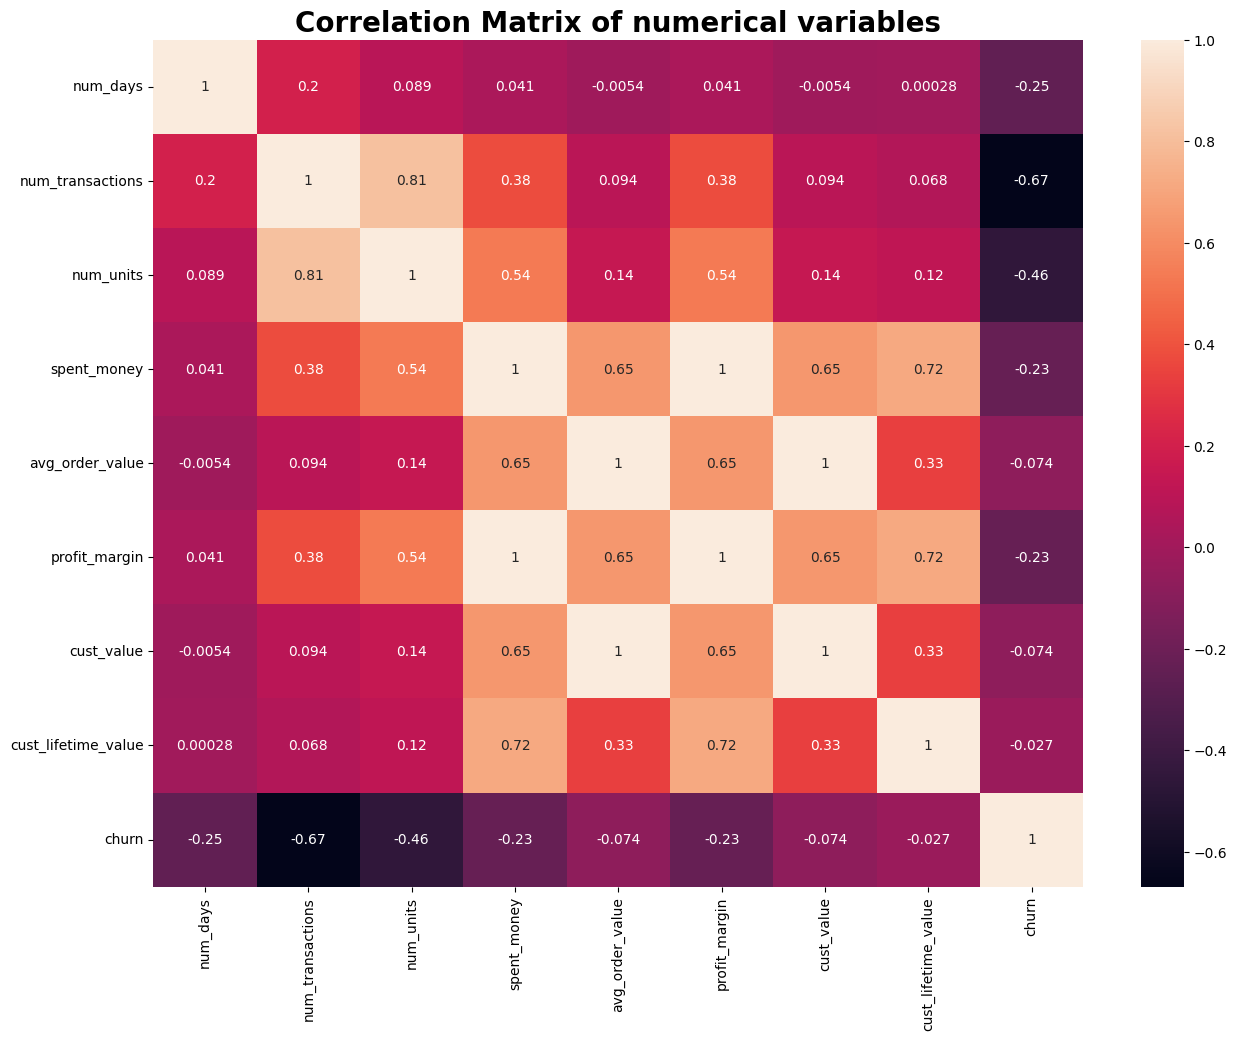

In [26]:
plt.figure(figsize=(15,11))
sns.heatmap(FINALE.corr(), annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

In [27]:
new=pd.read_csv("E:/final.csv")

In [28]:
new

,Unnamed: 0,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,no_of_orders,purchased_approved,delivered_estimated,purchased_delivered,no_of_products,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,payment_type,payment_installments,payment_value,review_score
0,0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1,891.0,4,6.0,1,...,1500.0,34.0,7.0,32.0,-23.333580,-46.823060,credit_card,8,141.90,5.0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1,26057.0,4,3.0,1,...,375.0,26.0,11.0,18.0,-23.545029,-46.781482,credit_card,1,27.19,4.0
2,2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1,0.0,1,25.0,1,...,1500.0,25.0,50.0,35.0,-27.532246,-48.618667,credit_card,8,86.22,3.0
3,3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1,1176.0,11,20.0,1,...,150.0,19.0,5.0,11.0,-1.304189,-48.476339,credit_card,4,43.62,4.0
4,4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1,1270.0,7,13.0,1,...,6050.0,16.0,3.0,11.0,-23.496567,-47.462811,credit_card,6,196.89,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90523,90523,fffcf5a5ff07b0908bd4e2dbc735a684,55250,sanharo,PE,1,880.0,26,27.0,2,...,60000.0,110.0,150.0,122.0,-8.355933,-36.557540,credit_card,10,4134.84,5.0
90524,90524,fffea47cd6d3cc0a88bd621562a9d061,44054,feira de santana,BA,1,504.0,2,30.0,1,...,1720.0,33.0,36.0,27.0,-12.211251,-38.952416,credit_card,1,84.58,4.0
90525,90525,ffff371b4d645b6ecea244b27531430a,78552,sinop,MT,1,808.0,29,14.0,1,...,600.0,17.0,15.0,13.0,-11.819772,-55.496443,credit_card,1,112.46,5.0
90526,90526,ffff5962728ec6157033ef9805bacc48,29460,bom jesus do norte,ES,1,2466.0,13,11.0,1,...,444.0,20.0,14.0,16.0,-21.120385,-41.665221,credit_card,5,133.69,5.0


In [29]:
new_final=pd.merge(new,FINALE,on='customer_unique_id',how='inner')

In [30]:
new_final.columns

Index(['Unnamed: 0', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'no_of_orders', 'purchased_approved',
       'delivered_estimated', 'purchased_delivered', 'no_of_products', 'price',
       'freight_value', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'geolocation_lat',
       'geolocation_lng', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'num_days', 'num_transactions',
       'num_units', 'spent_money', 'avg_order_value', 'profit_margin',
       'cust_value', 'cust_lifetime_value', 'churn'],
      dtype='object')

In [31]:
#model is overfitting 

In [32]:
def state_encoding(state):
    if state in ['RS', 'SC', 'PR']:
        return 'southern'
    elif state in ['SP', 'RJ', 'MG', 'ES']:
        return 'southeastern'
    elif state in ['MT', 'MS', 'GO', 'DF']:
        return 'centralwestern'
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return 'northeastern'
    else: 
        return 'northern'

In [33]:
new_final['customer_state'] = new_final['customer_state'].apply(state_encoding)

In [34]:
new_final.drop(columns=['customer_zip_code_prefix','customer_city','Unnamed: 0'],axis=1,inplace=True)

In [35]:
new_final

,customer_unique_id,customer_state,no_of_orders,purchased_approved,delivered_estimated,purchased_delivered,no_of_products,price,freight_value,product_weight_g,...,review_score,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,cust_value,cust_lifetime_value,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,southeastern,1,891.0,4,6.0,1,129.90,12.00,1500.0,...,5.0,0,1,1,141.90,141.90,7.0950,206.630639,1466.044381,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,southeastern,1,26057.0,4,3.0,1,18.90,8.29,375.0,...,4.0,0,1,1,27.19,27.19,1.3595,39.593284,53.827070,1
2,0000f46a3911fa3c0805444483337064,southern,1,0.0,1,25.0,1,69.00,17.22,1500.0,...,3.0,0,1,1,86.22,86.22,4.3110,125.551048,541.250566,1
3,0000f6ccb0745a6a4b88665a16c9f078,northern,1,1176.0,11,20.0,1,25.99,17.63,150.0,...,4.0,0,1,1,43.62,43.62,2.1810,63.518171,138.533131,1
4,0004aac84e0df4da2b147fca70cf8255,southeastern,1,1270.0,7,13.0,1,180.00,16.89,6050.0,...,5.0,0,1,1,196.89,196.89,9.8445,286.705472,2822.472016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89934,fffcf5a5ff07b0908bd4e2dbc735a684,northeastern,1,880.0,26,27.0,2,1570.00,497.42,60000.0,...,5.0,0,2,3,4134.84,2067.42,206.7420,3010.516666,622400.236567,0
89935,fffea47cd6d3cc0a88bd621562a9d061,northeastern,1,504.0,2,30.0,1,64.89,19.69,1720.0,...,4.0,0,1,1,84.58,84.58,4.2290,123.162928,520.856020,1
89936,ffff371b4d645b6ecea244b27531430a,centralwestern,1,808.0,29,14.0,1,89.90,22.56,600.0,...,5.0,0,1,1,112.46,112.46,5.6230,163.760970,920.827933,1
89937,ffff5962728ec6157033ef9805bacc48,southeastern,1,2466.0,13,11.0,1,115.00,18.69,444.0,...,5.0,0,1,1,133.69,133.69,6.6845,194.675476,1301.308221,1


In [36]:
new_final.churn.value_counts()

1    76400
0    13539
Name: churn, dtype: int64

In [37]:
from imblearn.over_sampling import RandomOverSampler

In [38]:
X = new_final.drop(columns=['churn'])
y = new_final['churn']
ros = RandomOverSampler(random_state=42)

# Upsample the minority class
X_resampled, y_resampled = ros.fit_resample(X, y)

# Now, X_resampled and y_resampled contain the balanced dataset
# You can save these to a new CSV file if needed
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
resampled_df.to_csv('balanced_dataset.csv', index=False)

In [39]:
resampled_df.churn.value_counts()

1    76400
0    76400
Name: churn, dtype: int64

In [40]:
resampled_df['payment_type'].value_counts()

credit_card    107429
boleto          27916
voucher         15312
debit_card       2143
Name: payment_type, dtype: int64

In [41]:
resampled_df['customer_state'].value_counts()

southeastern      105508
southern           21894
northeastern       13895
centralwestern      8829
northern            2674
Name: customer_state, dtype: int64

In [42]:
clv_churn=pd.get_dummies(resampled_df,columns=['payment_type','customer_state'])

In [43]:
clv_churn.drop(columns=['customer_unique_id'],axis=1,inplace=True)

In [44]:
clv_churn

,no_of_orders,purchased_approved,delivered_estimated,purchased_delivered,no_of_products,price,freight_value,product_weight_g,product_length_cm,product_height_cm,...,churn,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,customer_state_centralwestern,customer_state_northeastern,customer_state_northern,customer_state_southeastern,customer_state_southern
0,1,891.0,4,6.0,1,129.90,12.00,1500.0,34.0,7.0,...,1,0,1,0,0,0,0,0,1,0
1,1,26057.0,4,3.0,1,18.90,8.29,375.0,26.0,11.0,...,1,0,1,0,0,0,0,0,1,0
2,1,0.0,1,25.0,1,69.00,17.22,1500.0,25.0,50.0,...,1,0,1,0,0,0,0,0,0,1
3,1,1176.0,11,20.0,1,25.99,17.63,150.0,19.0,5.0,...,1,0,1,0,0,0,0,1,0,0
4,1,1270.0,7,13.0,1,180.00,16.89,6050.0,16.0,3.0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152795,1,33490.0,-5,28.0,1,160.80,31.34,9650.0,122.0,68.0,...,0,0,1,0,0,0,0,0,1,0
152796,1,10948.0,8,16.0,1,113.98,30.30,800.0,36.0,22.0,...,0,0,1,0,0,0,0,0,1,0
152797,1,1459.0,18,14.0,1,199.80,44.82,2600.0,60.0,32.0,...,0,0,0,0,1,0,0,0,1,0
152798,1,956.0,8,19.0,1,245.80,36.86,3600.0,60.0,10.0,...,0,0,0,0,1,0,1,0,0,0


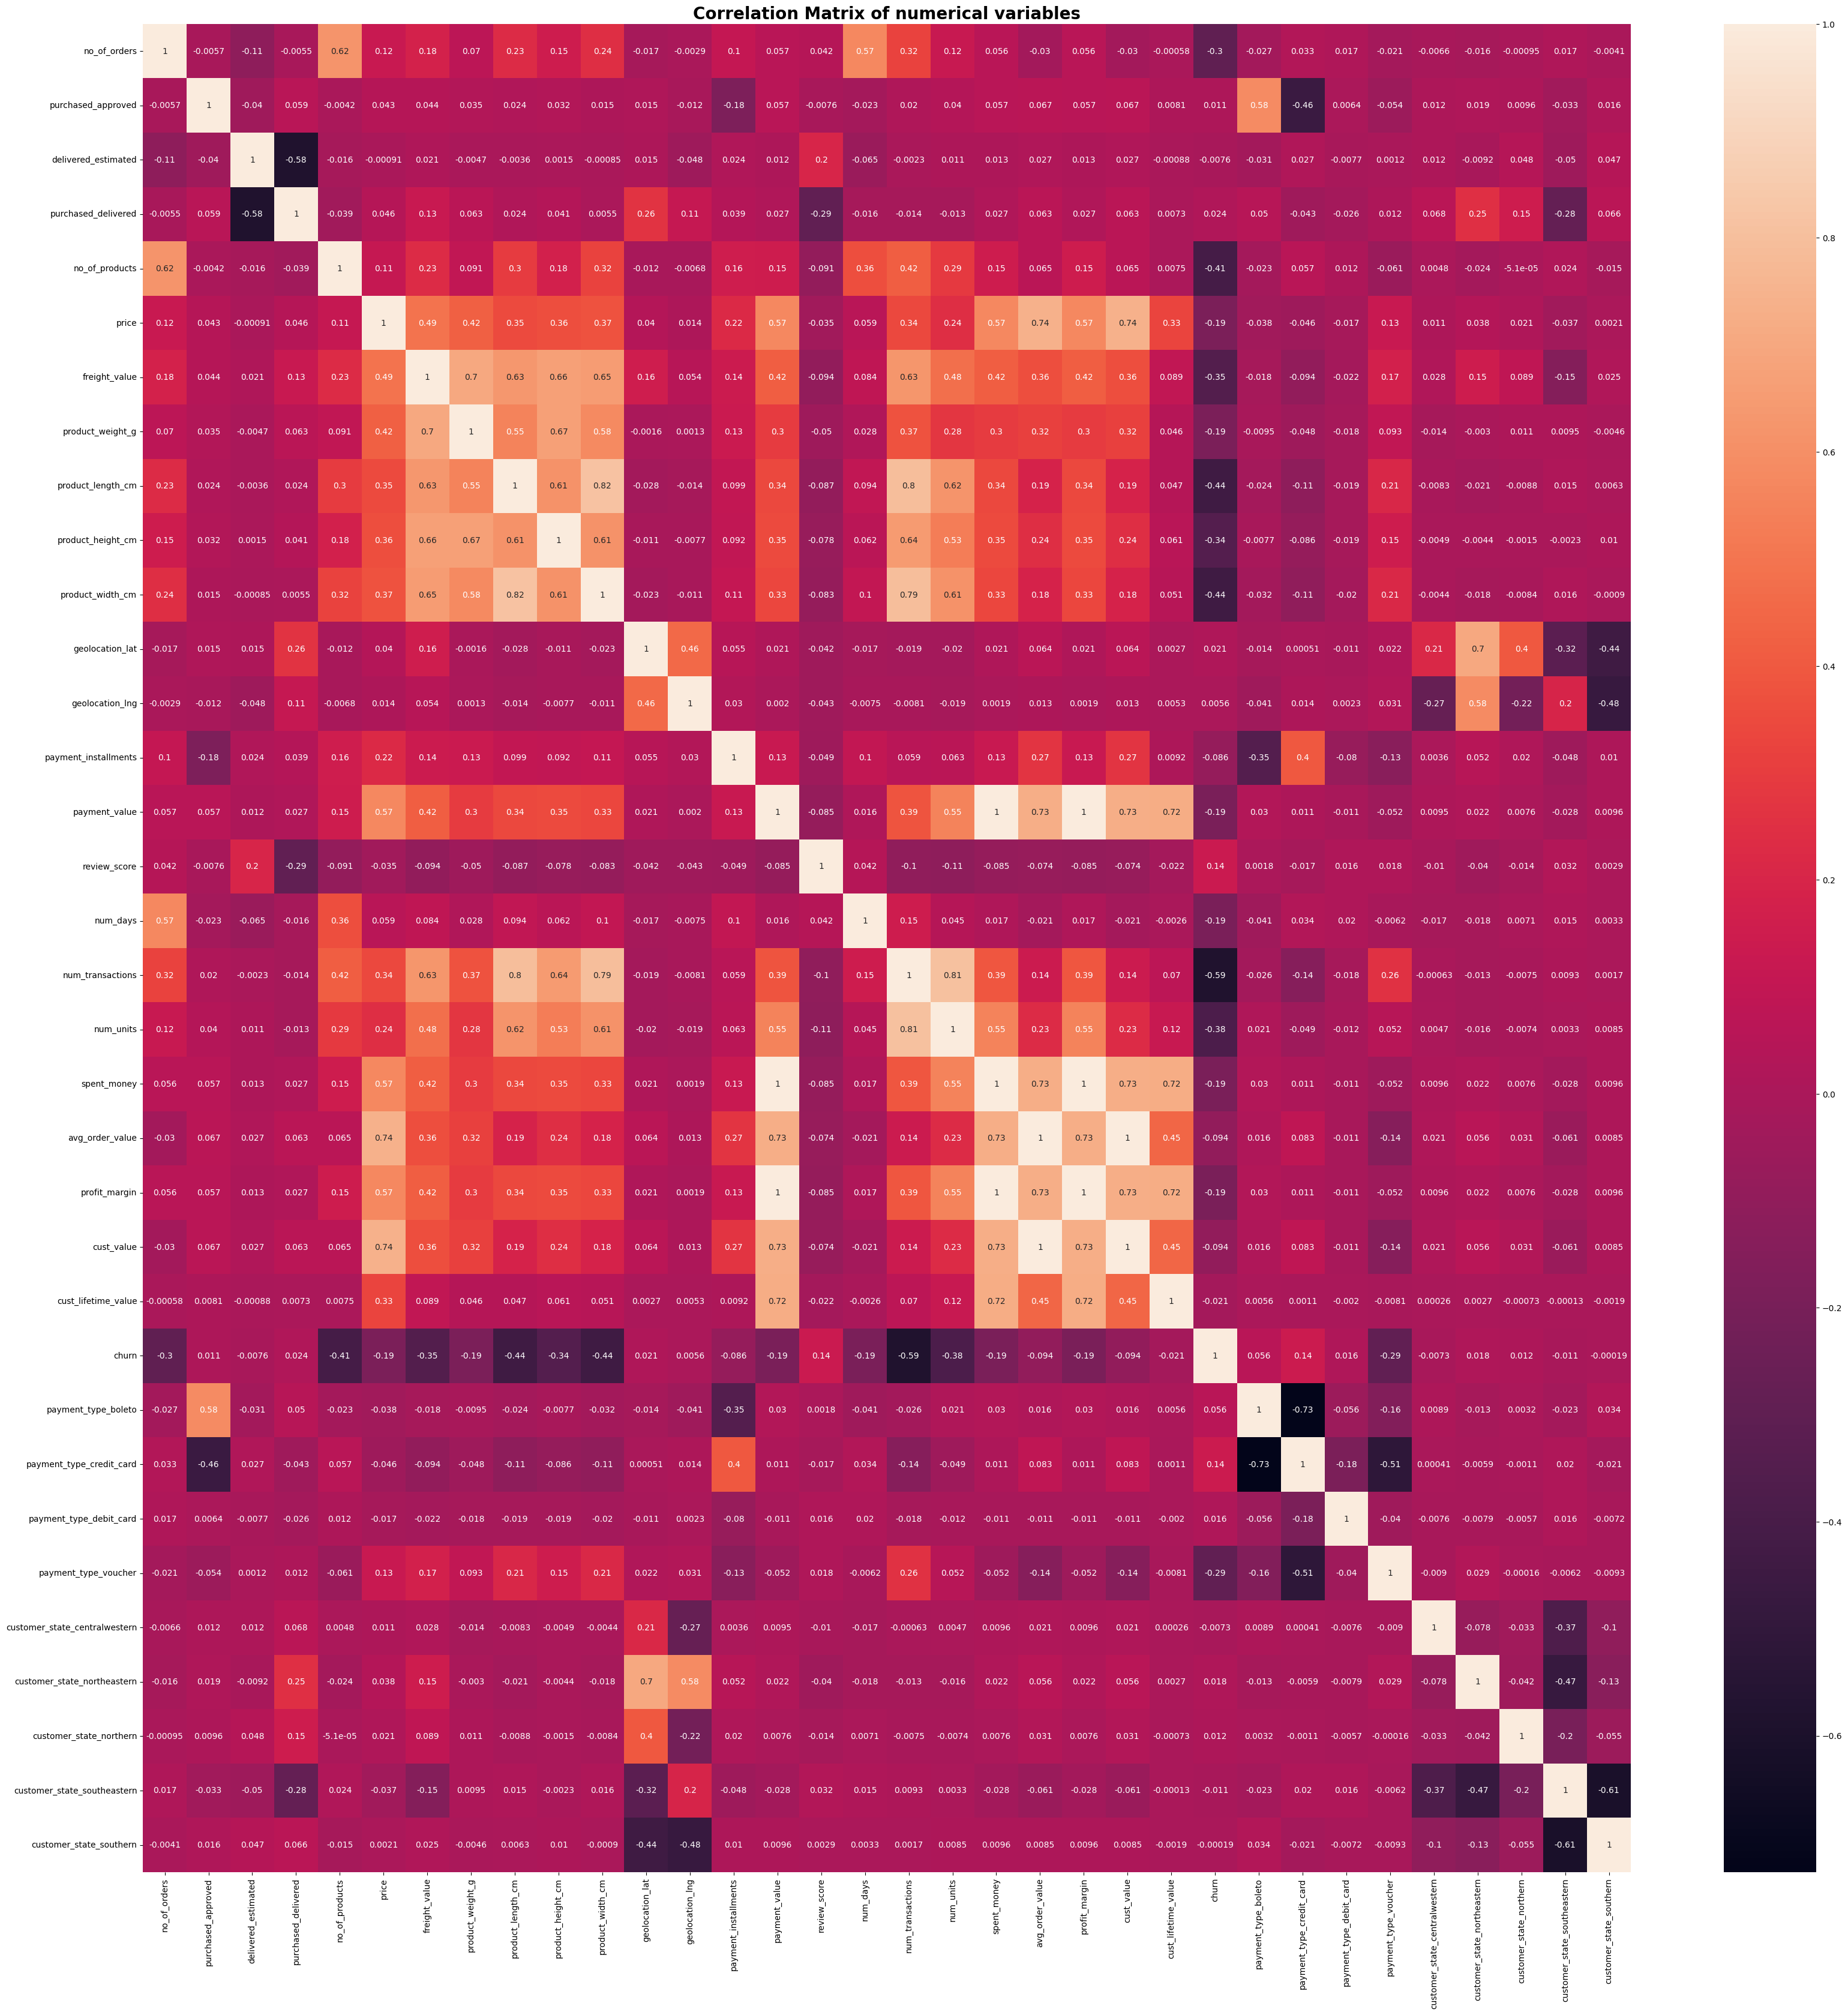

In [45]:
plt.figure(figsize=(40,40))
sns.heatmap(clv_churn.corr(), annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
for var in clv_churn:
    if var in ['delivered_estimated','geolocation_lat','geolocation_lng']:
        clv_churn[var] = pt.fit_transform(clv_churn[[var]])

In [47]:
 clv_churn

,no_of_orders,purchased_approved,delivered_estimated,purchased_delivered,no_of_products,price,freight_value,product_weight_g,product_length_cm,product_height_cm,...,churn,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,customer_state_centralwestern,customer_state_northeastern,customer_state_northern,customer_state_southeastern,customer_state_southern
0,1,891.0,-0.801565,6.0,1,129.90,12.00,1500.0,34.0,7.0,...,1,0,1,0,0,0,0,0,1,0
1,1,26057.0,-0.801565,3.0,1,18.90,8.29,375.0,26.0,11.0,...,1,0,1,0,0,0,0,0,1,0
2,1,0.0,-1.085251,25.0,1,69.00,17.22,1500.0,25.0,50.0,...,1,0,1,0,0,0,0,0,0,1
3,1,1176.0,-0.053637,20.0,1,25.99,17.63,150.0,19.0,5.0,...,1,0,1,0,0,0,0,1,0,0
4,1,1270.0,-0.491859,13.0,1,180.00,16.89,6050.0,16.0,3.0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152795,1,33490.0,-1.511551,28.0,1,160.80,31.34,9650.0,122.0,68.0,...,0,0,1,0,0,0,0,0,1,0
152796,1,10948.0,-0.384643,16.0,1,113.98,30.30,800.0,36.0,22.0,...,0,0,1,0,0,0,0,0,1,0
152797,1,1459.0,0.760633,14.0,1,199.80,44.82,2600.0,60.0,32.0,...,0,0,0,0,1,0,0,0,1,0
152798,1,956.0,-0.384643,19.0,1,245.80,36.86,3600.0,60.0,10.0,...,0,0,0,0,1,0,1,0,0,0


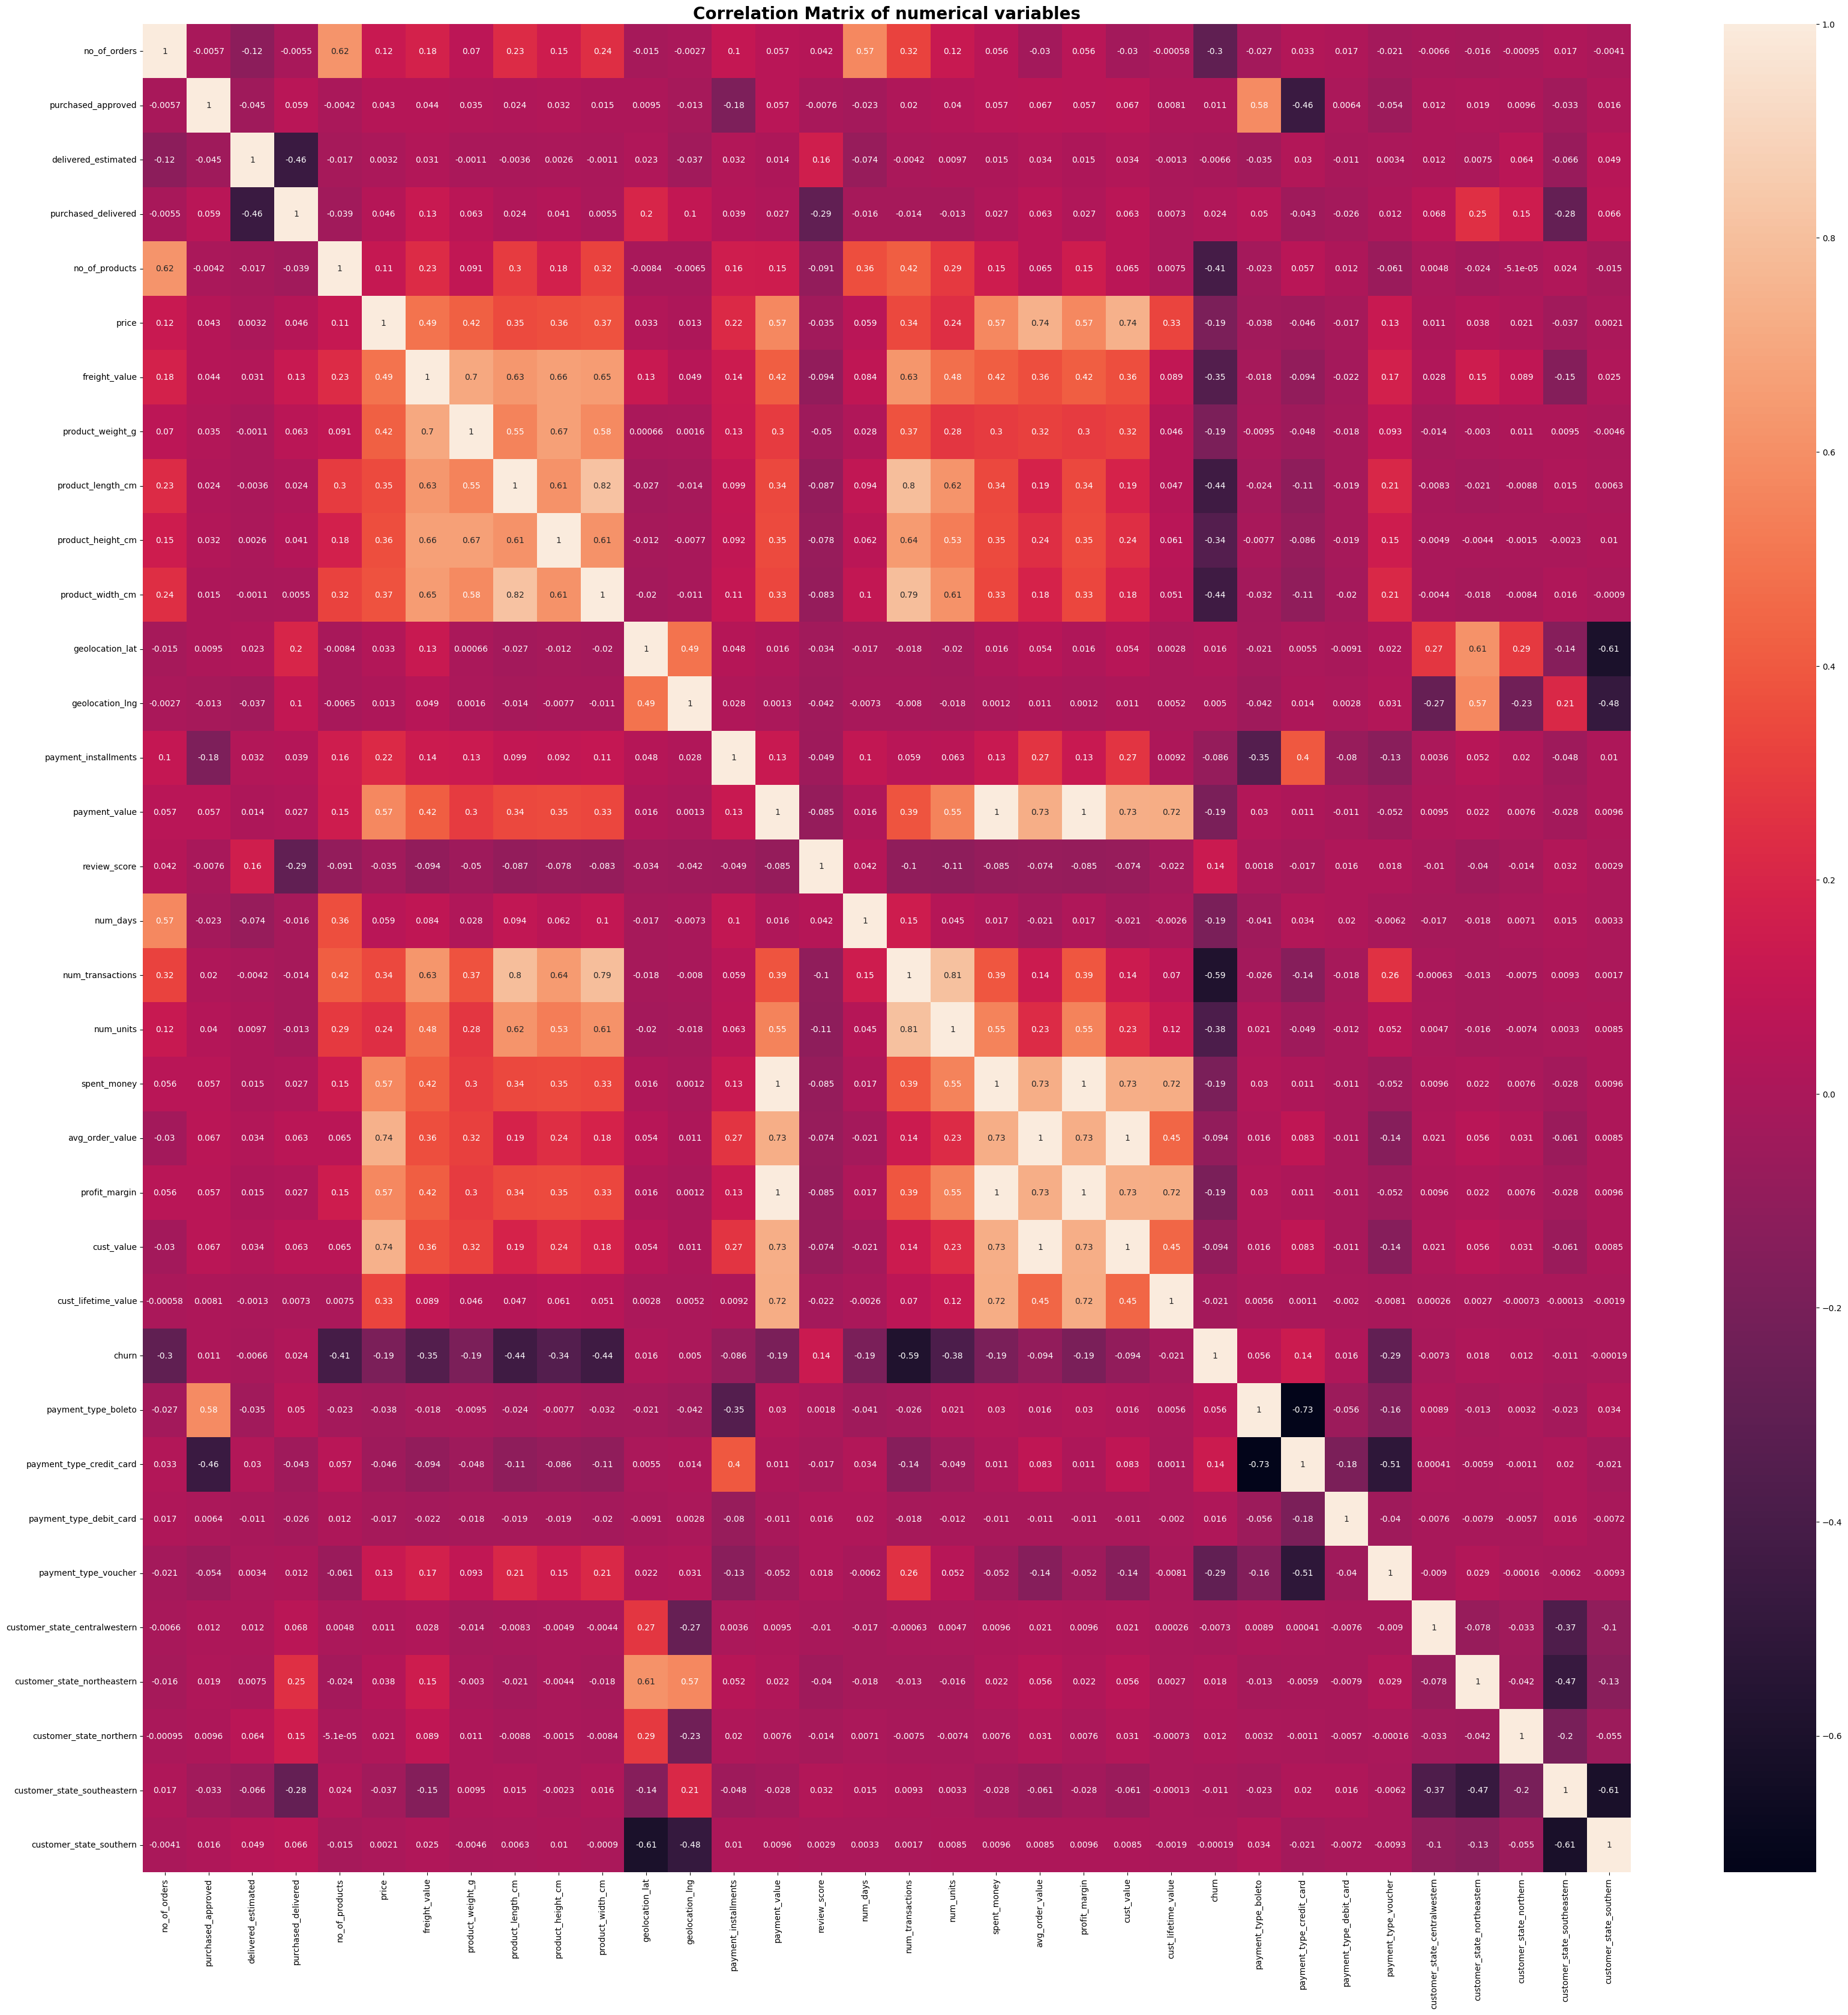

In [48]:
plt.figure(figsize=(40,40))
sns.heatmap(clv_churn.corr(), annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

In [49]:
from pycaret.classification import *

In [50]:
best=setup(data=clv_churn,target='churn',fold=16)

,Description,Value
0,Session id,2464
1,Target,churn
2,Target type,Binary
3,Original data shape,"(152800, 34)"
4,Transformed data shape,"(152800, 34)"
5,Transformed train set shape,"(106960, 34)"
6,Transformed test set shape,"(45840, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


In [51]:
exclude=['dt','rf','ada','gbc','xgboost','lightgbm','et','lr','qda']
compare_models(exclude=exclude)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9057,0.9636,0.8696,0.9372,0.9022,0.8114,0.8135,2.8850
svm,SVM - Linear Kernel,0.8861,0.0000,0.9195,0.8691,0.8787,0.7723,0.7882,1.2969
ridge,Ridge Classifier,0.8772,0.0000,0.9846,0.8105,0.8891,0.7543,0.7724,1.3031
lda,Linear Discriminant Analysis,0.8772,0.9883,0.9846,0.8105,0.8891,0.7543,0.7724,1.4950
nb,Naive Bayes,0.6489,0.8820,0.9691,0.5908,0.7340,0.2977,0.3876,1.2794
dummy,Dummy Classifier,0.4999,0.5000,0.5000,0.2500,0.3333,0.0000,0.0000,1.1844


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6545,0.8872,0.9692,0.5948,0.7372,0.3088,0.3975
1,0.6477,0.8745,0.9644,0.5905,0.7325,0.2954,0.3817
2,0.6443,0.8804,0.9677,0.5876,0.7312,0.2885,0.3783
3,0.6444,0.8775,0.9665,0.5879,0.7311,0.2888,0.3776
4,0.6461,0.8855,0.9743,0.5882,0.7336,0.2921,0.3872
5,0.6524,0.8882,0.9695,0.5933,0.7361,0.3046,0.3941
6,0.6461,0.8832,0.9704,0.5886,0.7328,0.2921,0.3838
7,0.6628,0.8859,0.9698,0.6009,0.7420,0.3256,0.4125
8,0.6546,0.8877,0.9707,0.5947,0.7375,0.3093,0.3991


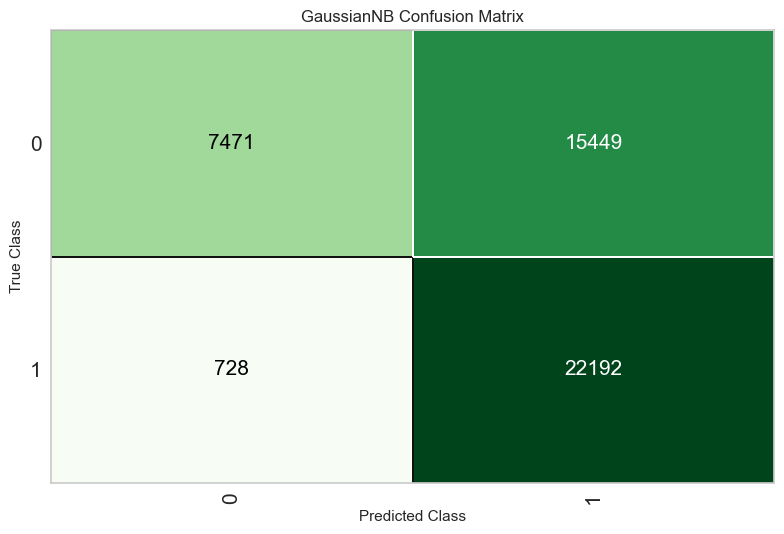

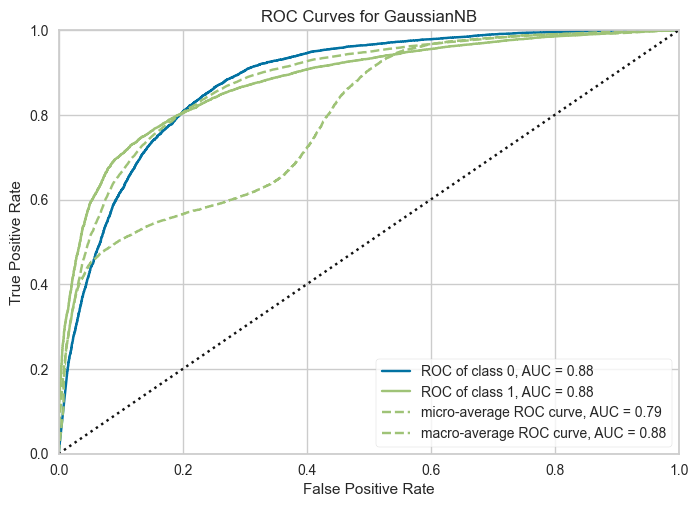

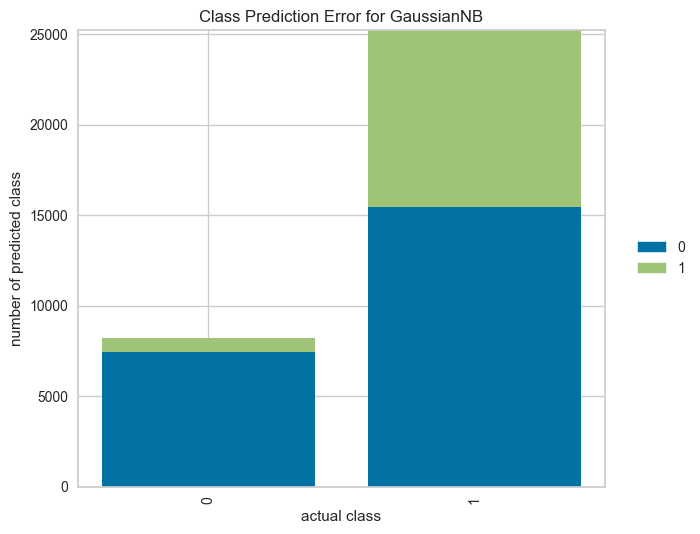

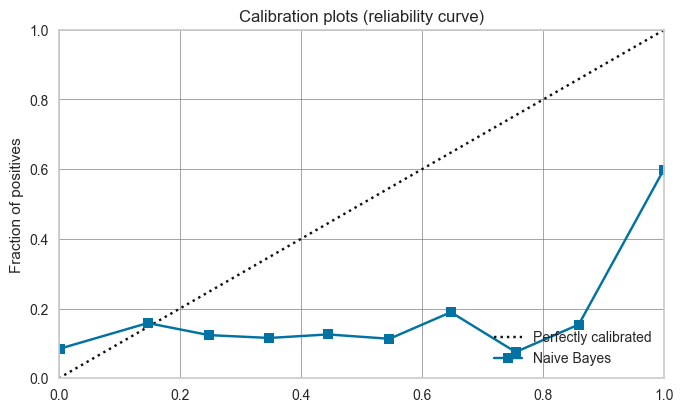

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [52]:
model1=create_model('nb')
plot_model(model1,plot='confusion_matrix')
plot_model(model1,plot='auc')
plot_model(model1,plot='error')
plot_model(model1,plot='calibration')
evaluate_model(model1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9119,0.9651,0.8806,0.9394,0.9091,0.8238,0.8254
1,0.9014,0.9650,0.8612,0.9366,0.8973,0.8028,0.8055
2,0.9049,0.9644,0.8711,0.9342,0.9015,0.8097,0.8116
3,0.9023,0.9617,0.8624,0.9373,0.8983,0.8046,0.8072
4,0.9034,0.9641,0.8687,0.9335,0.8999,0.8067,0.8087
5,0.9053,0.9649,0.8678,0.9382,0.9016,0.8106,0.8129
6,0.9002,0.9629,0.8579,0.9373,0.8958,0.8005,0.8033
7,0.9056,0.9629,0.8669,0.9397,0.9018,0.8112,0.8137
8,0.9138,0.9664,0.8788,0.9450,0.9107,0.8277,0.8297


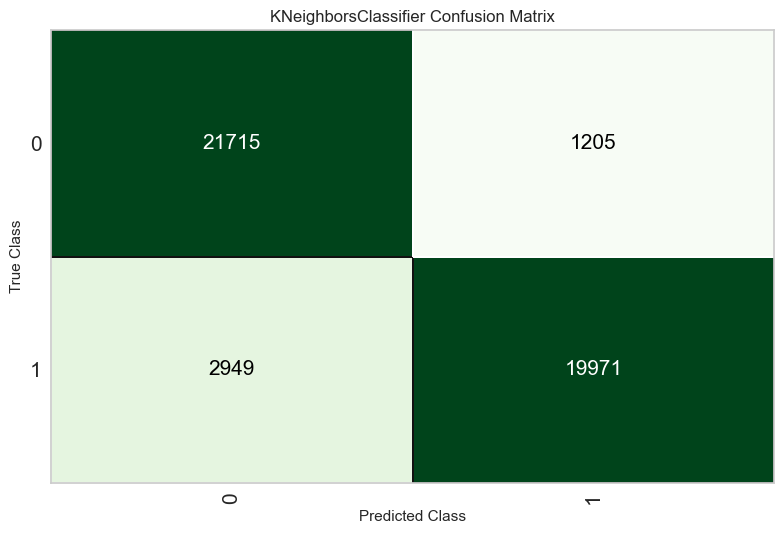

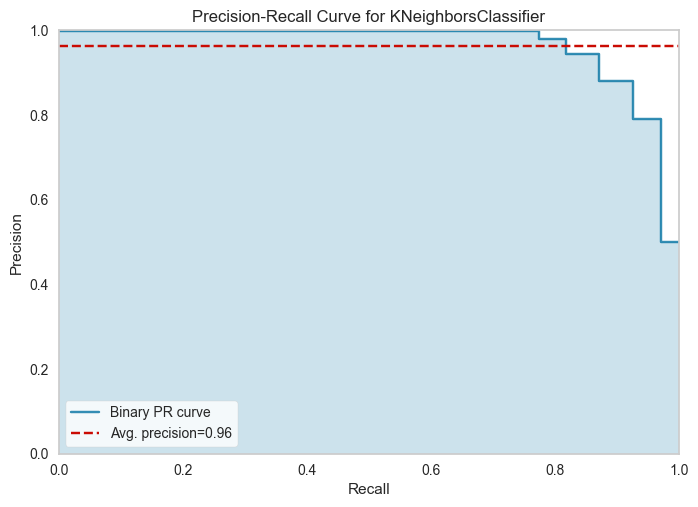

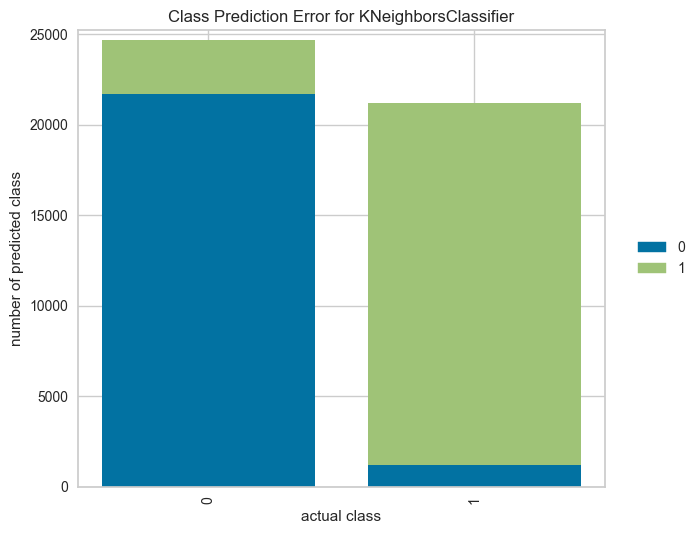

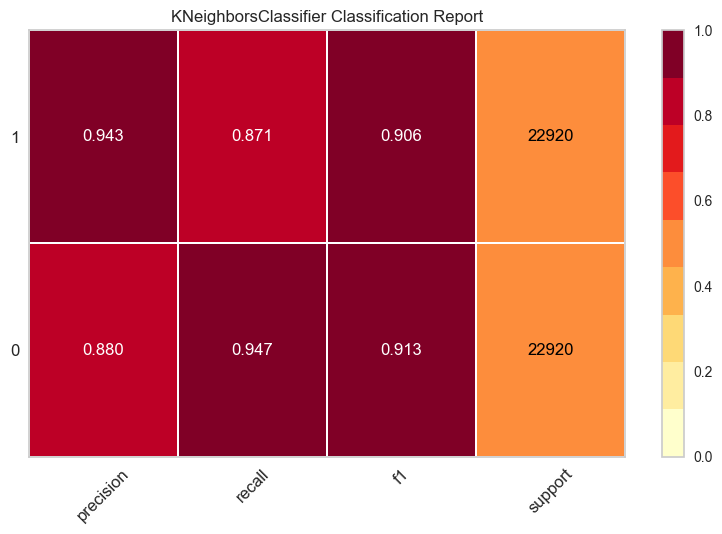

,Parameters
algorithm,auto
leaf_size,30
metric,minkowski
metric_params,None
n_jobs,-1
n_neighbors,5
p,2
weights,uniform


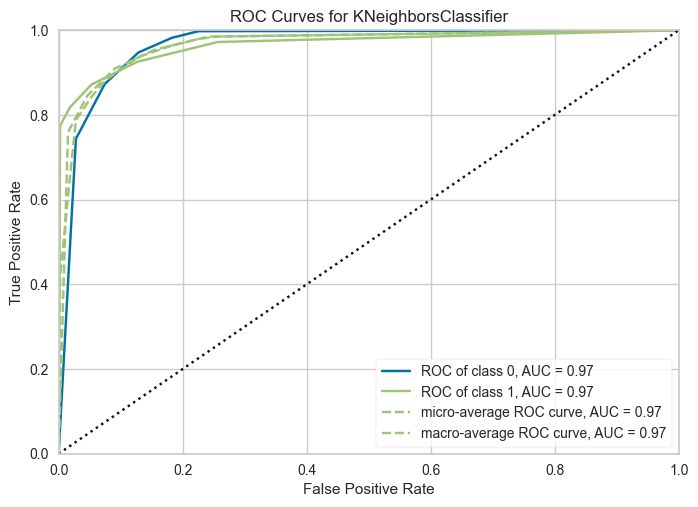

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [53]:
model2=create_model('knn')
plot_model(model2,plot='confusion_matrix')
plot_model(model2,plot='pr')
plot_model(model2,plot='error')
plot_model(model2,plot='class_report')
plot_model(model2,plot='parameter')
plot_model(model2,plot='auc')
evaluate_model(model2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8694,0.0000,0.9853,0.7999,0.8830,0.7388,0.7595
1,0.8839,0.0000,0.9865,0.8186,0.8947,0.7678,0.7845
2,0.8766,0.0000,0.9821,0.8110,0.8884,0.7532,0.7705
3,0.8835,0.0000,0.9824,0.8202,0.8940,0.7669,0.7824
4,0.8763,0.0000,0.9824,0.8105,0.8882,0.7526,0.7701
5,0.8815,0.0000,0.9850,0.8161,0.8927,0.7630,0.7799
6,0.8806,0.0000,0.9889,0.8129,0.8923,0.7612,0.7798
7,0.8814,0.0000,0.9856,0.8156,0.8926,0.7627,0.7799
8,0.8809,0.0000,0.9829,0.8164,0.8919,0.7619,0.7782


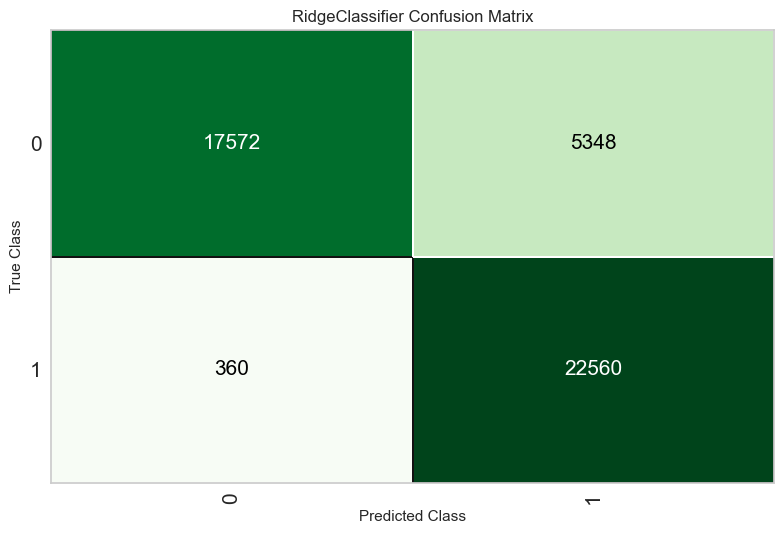

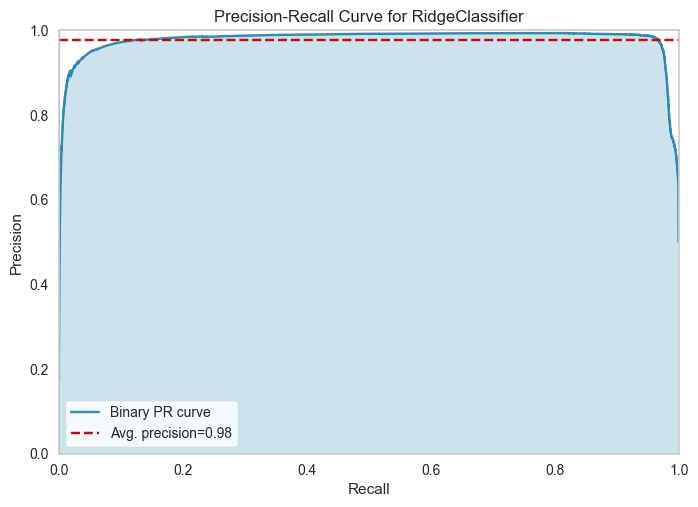

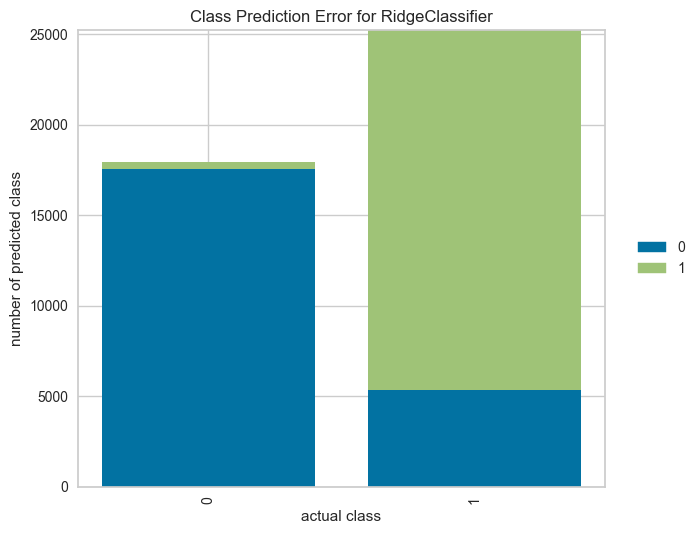

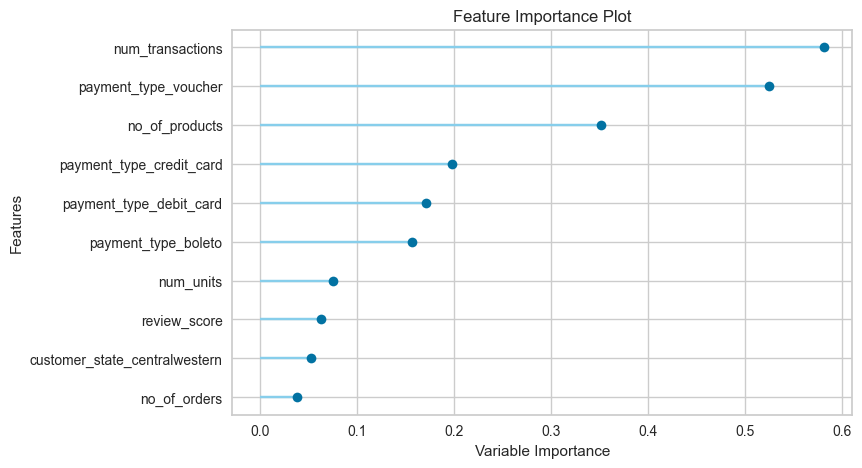

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [54]:
model3=create_model('ridge')
plot_model(model3,plot='confusion_matrix')
plot_model(model3,plot='pr')
plot_model(model3,plot='error')
plot_model(model3,plot='feature')
evaluate_model(model3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8694,0.9880,0.9853,0.7999,0.8830,0.7388,0.7595
1,0.8839,0.9892,0.9865,0.8186,0.8947,0.7678,0.7845
2,0.8766,0.9872,0.9821,0.8110,0.8884,0.7532,0.7705
3,0.8835,0.9892,0.9824,0.8202,0.8940,0.7669,0.7824
4,0.8763,0.9887,0.9824,0.8105,0.8882,0.7526,0.7701
5,0.8815,0.9900,0.9850,0.8161,0.8927,0.7630,0.7799
6,0.8806,0.9893,0.9889,0.8129,0.8923,0.7612,0.7798
7,0.8814,0.9887,0.9856,0.8156,0.8926,0.7627,0.7799
8,0.8809,0.9876,0.9829,0.8164,0.8919,0.7619,0.7782


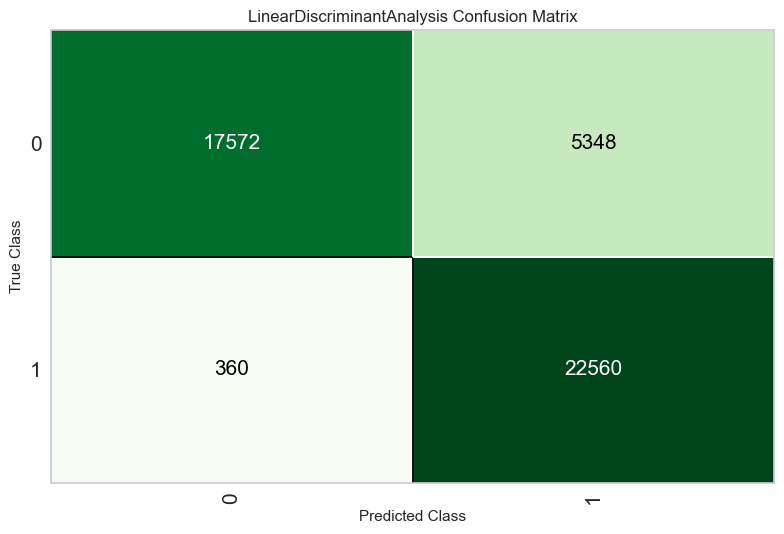

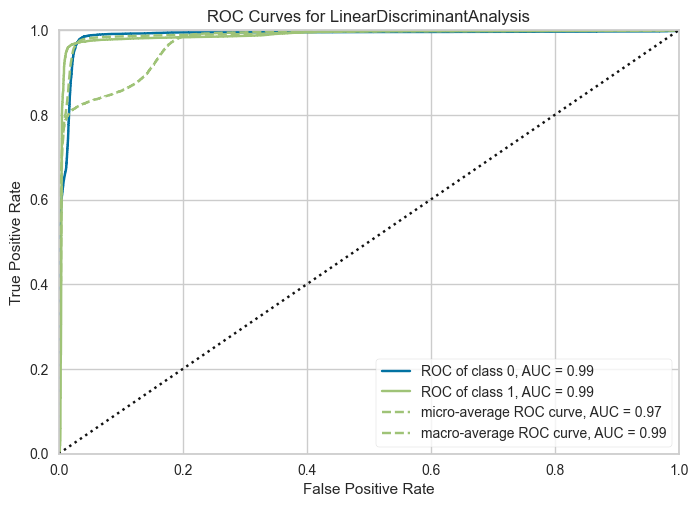

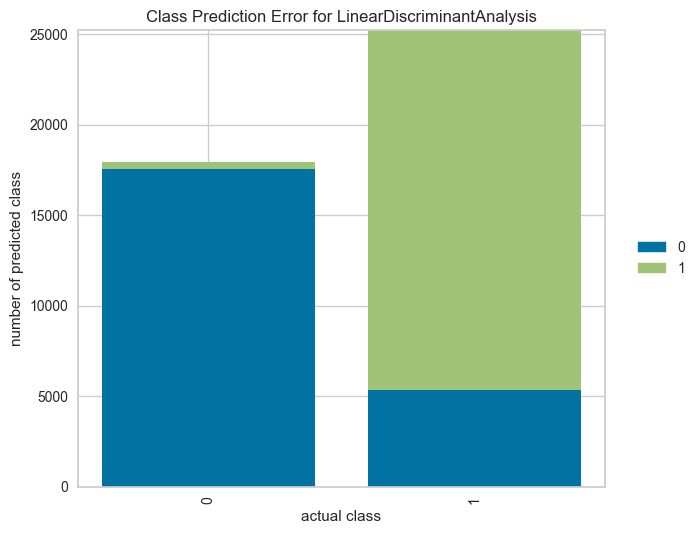

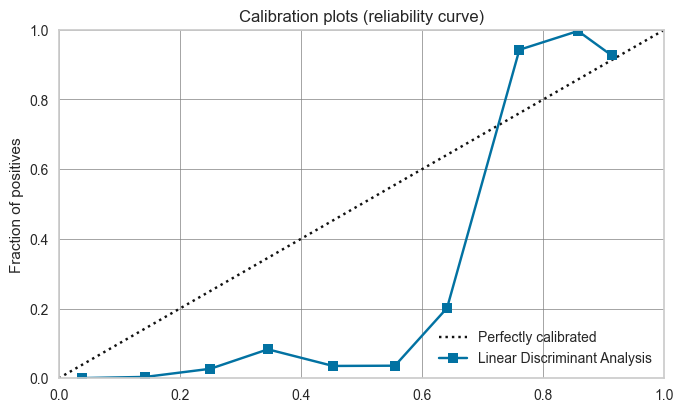

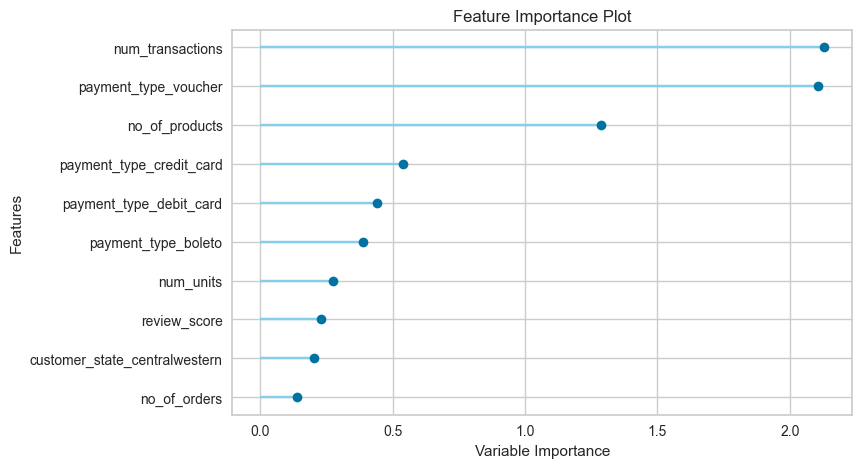

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [55]:
model4=create_model('lda')
plot_model(model4,plot='confusion_matrix')
plot_model(model4,plot='auc')
plot_model(model4,plot='error')
plot_model(model4,plot='calibration')
plot_model(model4,plot='feature')
evaluate_model(model4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.4999,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.4999,0.5000,1.0000,0.4999,0.6666,0.0000,0.0000


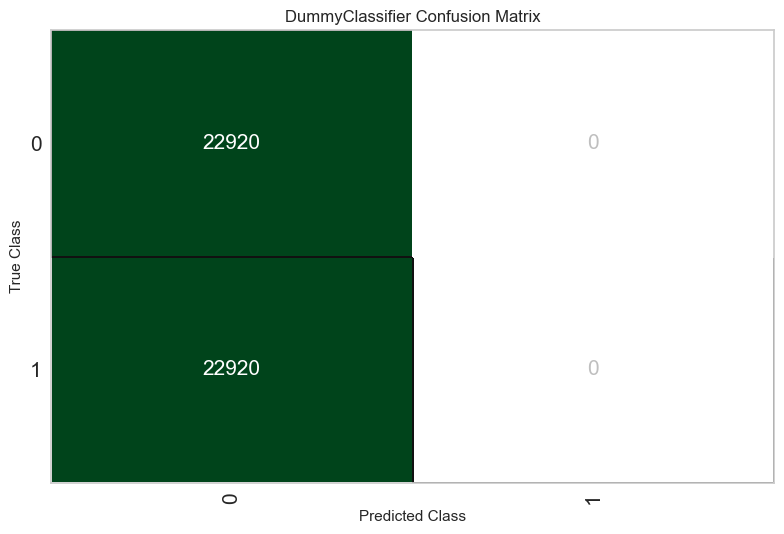

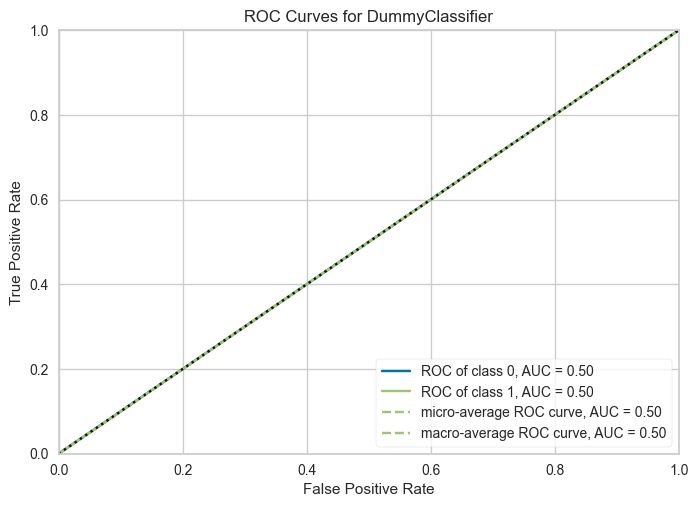

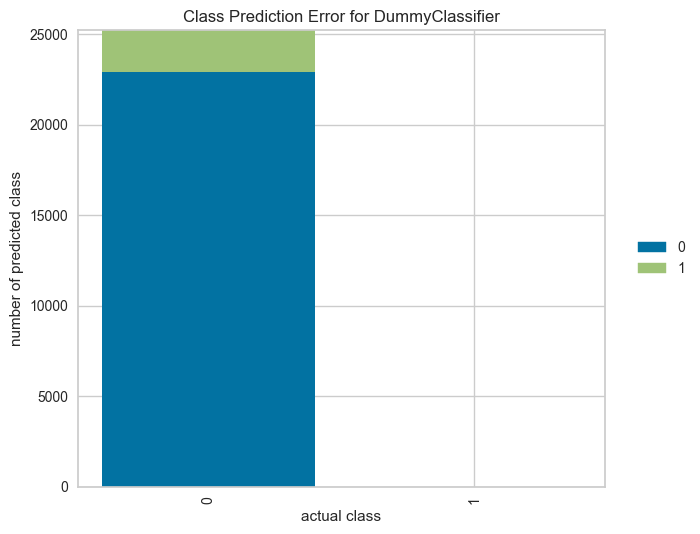

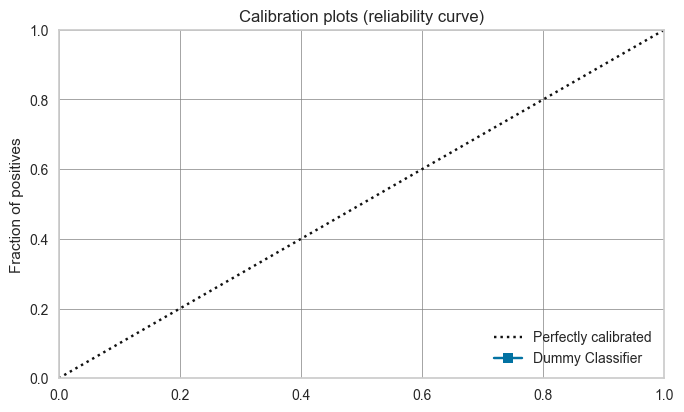

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [56]:
model6=create_model('dummy')
plot_model(model6,plot='confusion_matrix')
plot_model(model6,plot='auc')
plot_model(model6,plot='error')
plot_model(model6,plot='calibration')
evaluate_model(model6)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5599,0.0000,0.1902,0.7302,0.3019,0.1199,0.1781
1,0.9665,0.0000,0.9991,0.9379,0.9676,0.9330,0.9350
2,0.9458,0.0000,0.9973,0.9043,0.9485,0.8917,0.8965
3,0.9286,0.0000,0.8786,0.9764,0.9249,0.8573,0.8616
4,0.9973,0.0000,0.9988,0.9958,0.9973,0.9946,0.9946
5,0.9975,0.0000,0.9964,0.9985,0.9975,0.9949,0.9949
6,0.9699,0.0000,0.9806,0.9602,0.9703,0.9399,0.9401
7,0.9734,0.0000,0.9859,0.9618,0.9737,0.9467,0.9470
8,0.8923,0.0000,0.9797,0.8339,0.9009,0.7846,0.7969


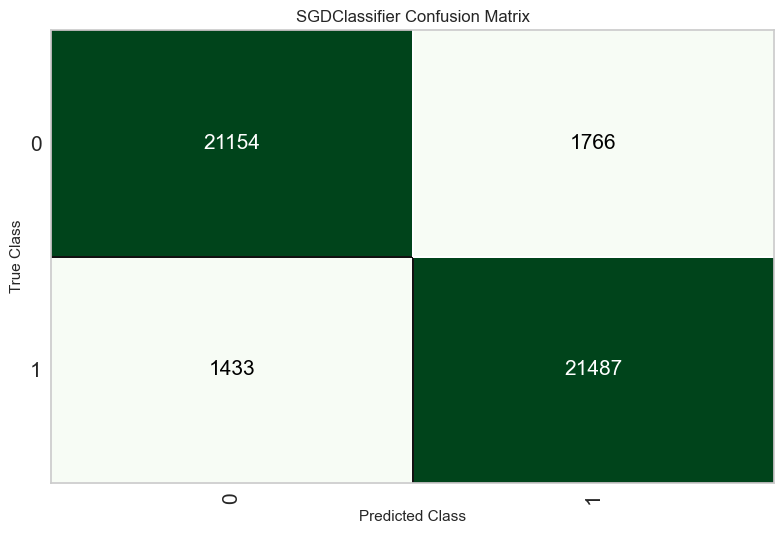

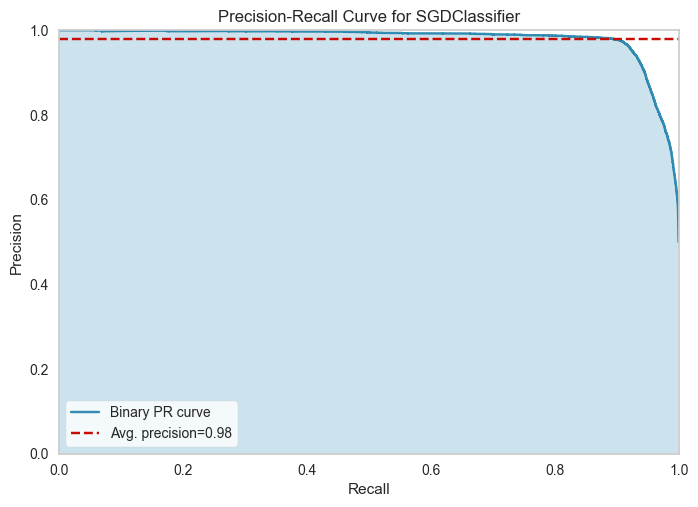

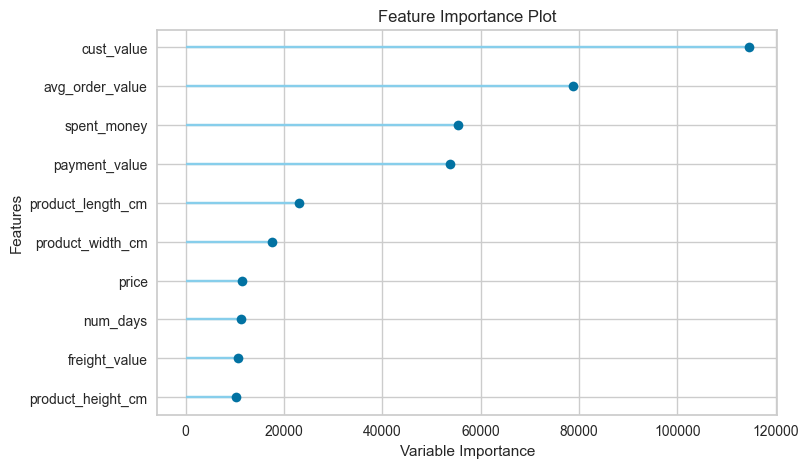

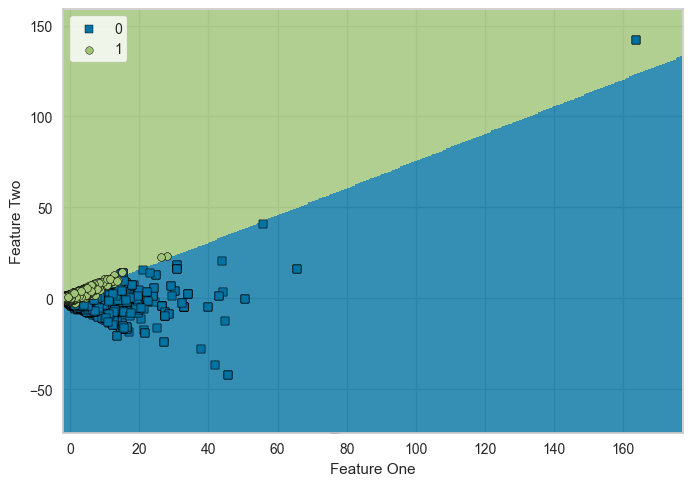

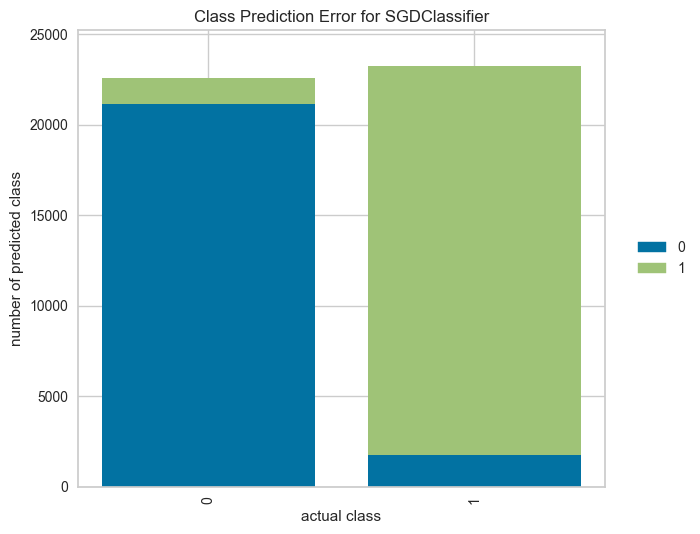

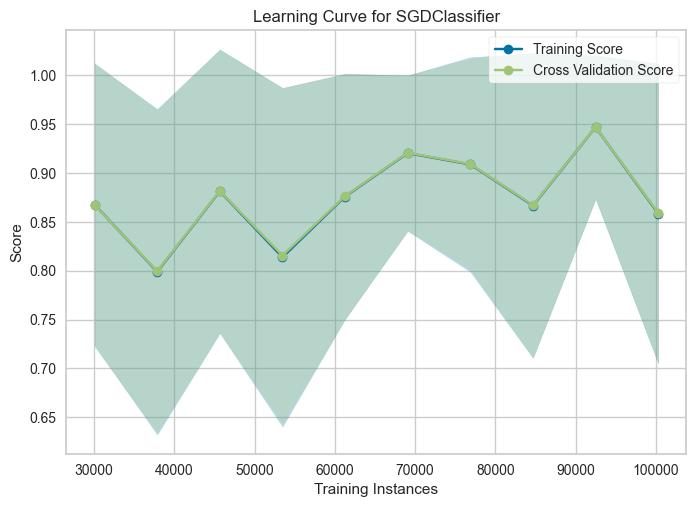

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [57]:
model7=create_model('svm')
plot_model(model7,plot='confusion_matrix')
plot_model(model7,plot='pr')
plot_model(model7,plot='feature')
plot_model(model7,plot='boundary')
plot_model(model7,plot='error')
plot_model(model7,plot='learning')
evaluate_model(model7)